In [1]:
import seaborn as sb, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

In [2]:
df_train = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_testing-set.csv')

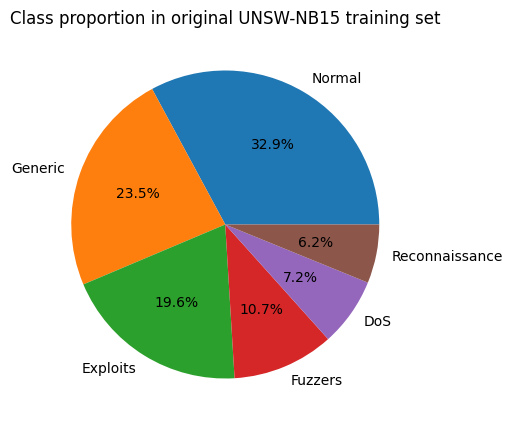

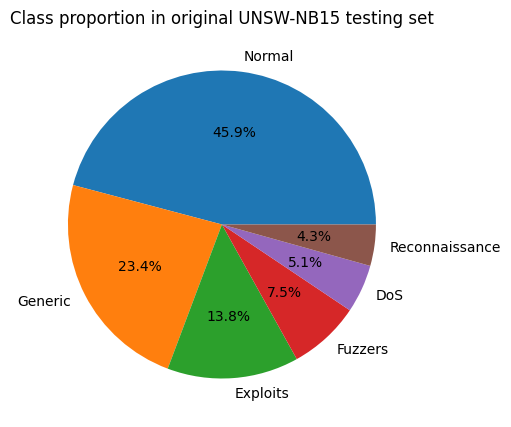

In [3]:
del df_train["id"]
del df_test["id"]

df_train["attack_cat"] = df_train["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 
df_test["attack_cat"] = df_test["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

plt.figure(figsize=(12,5))
plt.title("Class proportion in original UNSW-NB15 training set")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

plt.figure(figsize=(12,5))
plt.title("Class proportion in original UNSW-NB15 testing set")
plt.pie(df_test["attack_cat"].value_counts(normalize=True).values, labels=df_test["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

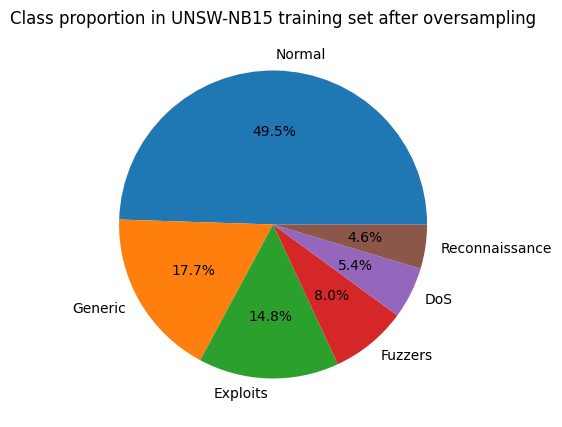

In [4]:
df_train_add = df_train[df_train["label"] == 0]

df_train = pd.concat([df_train,df_train_add])

plt.figure(figsize=(12,5))
plt.title("Class proportion in UNSW-NB15 training set after oversampling")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

In [5]:
enc = OrdinalEncoder().set_output(transform="pandas")
df_train["attack_cat"] = enc.fit_transform(df_train[["attack_cat"]])
df_test["attack_cat"] = enc.transform(df_test[["attack_cat"]])

df_train["attack_cat"] = df_train["attack_cat"].astype(int)
df_test["attack_cat"] = df_test["attack_cat"].astype(int)

In [6]:
numeric_cols = df_train.columns.difference(["service", "proto", "state", "attack_cat", "label"])
df_train_unduplicated = df_train.drop_duplicates()
X_train_num, y_train_und = df_train_unduplicated[numeric_cols],  df_train_unduplicated['attack_cat']
scaler = MinMaxScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [7]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
df_train_trans_cats = enc.fit_transform(df_train[["service", "proto", "state"]])
df_test_trans_cats = enc.transform(df_test[["service",  "proto", "state"]])

df_train = pd.concat([df_train, df_train_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)
df_test = pd.concat([df_test, df_test_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)

df_train = df_train[[c for c in df_train if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]
df_test = df_test[[c for c in df_test if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]

print(df_train.shape)

(226332, 196)


In [8]:
df_test, df_validation = train_test_split(df_test, test_size=0.5, random_state=13, shuffle=True, stratify=df_test["attack_cat"])
print(len(df_test), len(df_validation))
print(df_test["attack_cat"].value_counts())
print(df_validation["attack_cat"].value_counts())

40325 40325
attack_cat
4    18500
3     9436
1     5566
2     3031
0     2044
5     1748
Name: count, dtype: int64
attack_cat
4    18500
3     9435
1     5566
2     3031
0     2045
5     1748
Name: count, dtype: int64


In [9]:
# df_train_unduplicated = df_train.drop_duplicates()
# X_train_num, y_train_und = df_train_unduplicated.iloc[:, 0:39],  df_train_unduplicated.iloc[:, -2]

In [10]:
mutual_info = mutual_info_classif(X_train_num, y_train_und)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num.columns
mutual_info = mutual_info.sort_values(ascending = False)

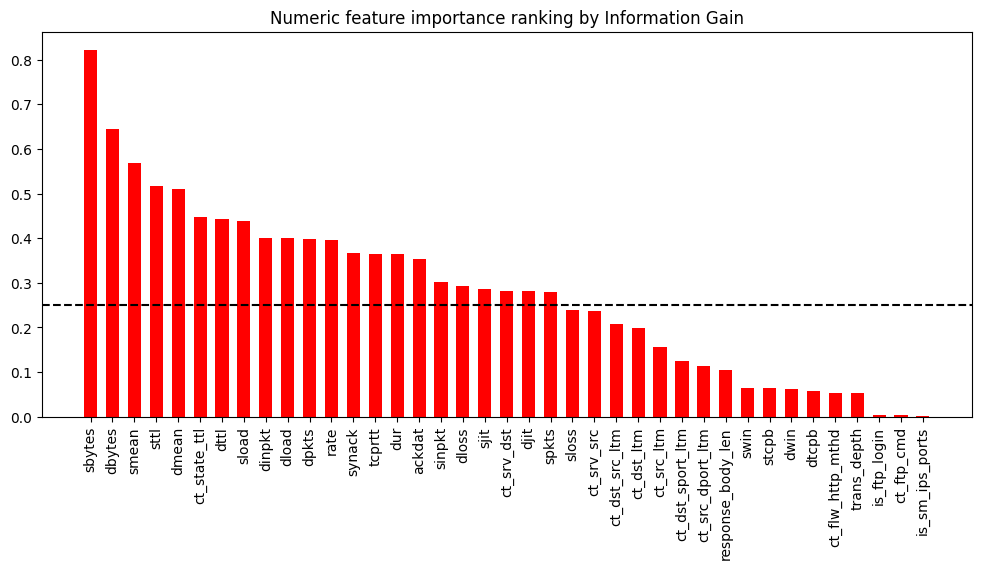

In [11]:
plt.figure(figsize=(12,5))
plt.title("Numeric feature importance ranking by Information Gain")
plt.bar(mutual_info.index, mutual_info, width=0.6, color="red")
plt.axhline(0.25, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

In [12]:
clf = RandomForestClassifier(n_estimators=1000, random_state=13)
clf = clf.fit(X_train_num, y_train_und)
rf_info = pd.Series(clf.feature_importances_)
rf_info.index = X_train_num.columns
rf_info = rf_info.sort_values(ascending = False)

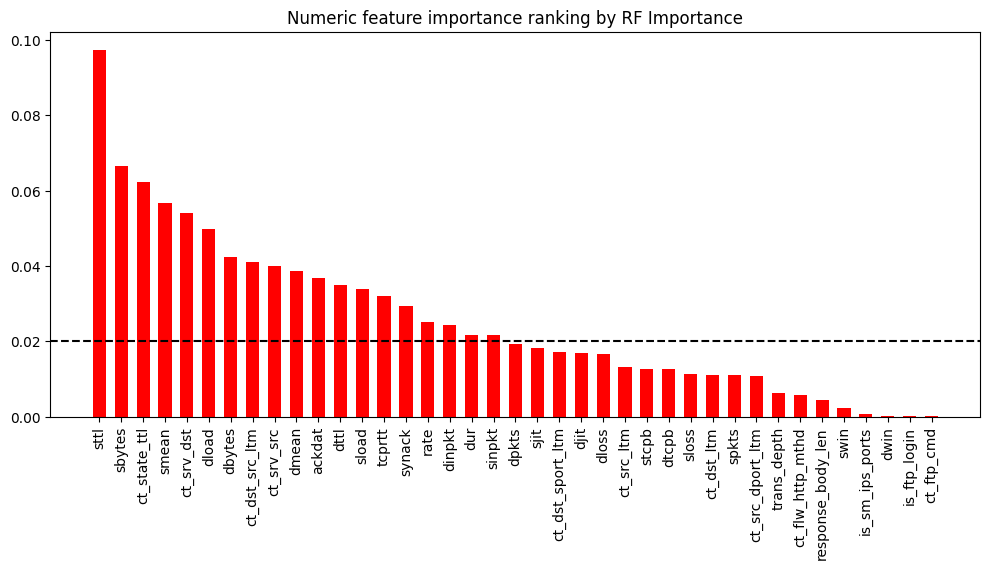

In [13]:
plt.figure(figsize=(12,5))
plt.title("Numeric feature importance ranking by RF Importance")
plt.bar(rf_info.index, rf_info, width=0.6, color="red")
plt.axhline(0.02, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

In [14]:
sel_mutual_info = mutual_info[mutual_info>0.25]
sel_rf_info = rf_info[rf_info>0.02]
igrf_intersection = set(sel_rf_info.index).intersection(set(sel_mutual_info.index))
igrf_union = set(sel_rf_info.index).union(set(sel_mutual_info.index))
print("IG: ", len(sel_mutual_info))
print("RF: ", len(sel_rf_info))
print("IGRF Intersection: ", len(igrf_intersection))
print("IGRF Union: ", len(igrf_union))

IG:  22
RF:  19
IGRF Intersection:  17
IGRF Union:  24


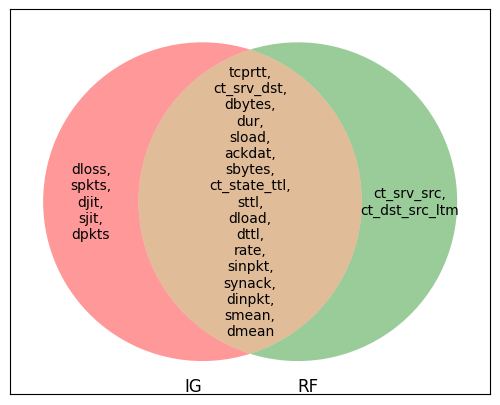

In [15]:
plt.figure(figsize=(12,5))
venn = venn2(subsets = (3, 3, 5), set_labels=('IG', 'RF'))
venn.get_label_by_id('100').set_text(',\n'.join(set(sel_mutual_info.index)-set(sel_rf_info.index)))
venn.get_label_by_id('110').set_text(',\n'.join(set(sel_mutual_info.index)&set(sel_rf_info.index)))
venn.get_label_by_id('010').set_text(',\n'.join(set(sel_rf_info.index)-set(sel_mutual_info.index)))
plt.axis('on')
plt.show()

In [16]:
X_train_cat = df_train.iloc[:, 39:-2]
X_test_cat = df_test.iloc[:, 39:-2]
X_validation_cat = df_test.iloc[:, 39:-2]

In [17]:
def eval_elimination(temp_rm, iters=10):
    columns = df_train.columns.difference(temp_rm + ['attack_cat', 'label'])
    X_train, y_train = df_train[columns], df_train.iloc[:, -2]
    X_validation, y_validation = df_validation[columns], df_validation.iloc[:, -2]
    score = 0
    for i in range(iters):
        model = MLPClassifier(activation="relu", solver="adam",
                          learning_rate="constant", learning_rate_init=0.01, 
                          batch_size=2048, max_iter=100, 
                          early_stopping=True, n_iter_no_change=10, random_state=13+(i*48))
        model.fit(X_train, y_train)
        y_preds = model.predict(X_validation)
        acc = accuracy_score(y_preds, y_validation)
        print(f"{i+1}: {acc}")
        score += acc

    return score/iters

In [18]:
p = 5
keep_features=list(igrf_union)+list(X_train_cat.columns)
rm_list = []
max_perforamnce = -1
selected_features = []
c = 0
while p > 0:
    c += 1
    performance_dict = {}
    for feature in keep_features:
        temp_rm = rm_list
        temp_rm.append(feature)
        print(feature)
        mean_score = eval_elimination(temp_rm, iters=1)
        print(f"mean: {mean_score}")
        performance_dict[feature] = mean_score

    least_imp_feature = max(performance_dict, key=performance_dict.get)
    rm_list.append(least_imp_feature)
    print(f"Least important feature for iteration {c}: {least_imp_feature}")
    print(f"features removed on iteration {c}: {rm_list}")
    keep_features.remove(least_imp_feature)
    if performance_dict[least_imp_feature] > max_perforamnce:
        max_perforamnce = performance_dict[least_imp_feature]
        selected_features = keep_features
        p = 5
    else:
        p -= 1

selected_features

djit
1: 0.8072907625542467
mean: 0.8072907625542467
spkts
1: 0.8131432114073156
mean: 0.8131432114073156
ct_state_ttl
1: 0.8053812771233726
mean: 0.8053812771233726
dload
1: 0.8093738375697458
mean: 0.8093738375697458
ct_dst_src_ltm
1: 0.8063484190948543
mean: 0.8063484190948543
synack
1: 0.80957222566646
mean: 0.80957222566646
sload
1: 0.8101425914445133
mean: 0.8101425914445133
smean
1: 0.8013639181649101
mean: 0.8013639181649101
dpkts
1: 0.8051084934903906
mean: 0.8051084934903906
ackdat
1: 0.803248605083695
mean: 0.803248605083695
sinpkt
1: 0.8009671419714817
mean: 0.8009671419714817
sbytes
1: 0.8043645381277124
mean: 0.8043645381277124
sttl
1: 0.7910477371357718
mean: 0.7910477371357718
dttl
1: 0.7953130812151271
mean: 0.7953130812151271
rate
1: 0.7980657160570366
mean: 0.7980657160570366
dinpkt
1: 0.7968753874767514
mean: 0.7968753874767514
sjit
1: 0.7938499690018599
mean: 0.7938499690018599
dmean
1: 0.7699194048357099
mean: 0.7699194048357099
tcprtt
1: 0.7588592684438934
mean: 0

['sload',
 'smean',
 'dpkts',
 'ackdat',
 'sinpkt',
 'sbytes',
 'sttl',
 'dttl',
 'rate',
 'dinpkt',
 'sjit',
 'dmean',
 'tcprtt',
 'dbytes',
 'dur',
 'ct_srv_src',
 'dloss',
 'ct_srv_dst',
 'service_-',
 'service_dhcp',
 'service_dns',
 'service_ftp',
 'service_ftp-data',
 'service_http',
 'service_irc',
 'service_pop3',
 'service_radius',
 'service_smtp',
 'service_snmp',
 'service_ssh',
 'service_ssl',
 'proto_3pc',
 'proto_a/n',
 'proto_aes-sp3-d',
 'proto_any',
 'proto_argus',
 'proto_aris',
 'proto_arp',
 'proto_ax.25',
 'proto_bbn-rcc',
 'proto_bna',
 'proto_br-sat-mon',
 'proto_cbt',
 'proto_cftp',
 'proto_chaos',
 'proto_compaq-peer',
 'proto_cphb',
 'proto_cpnx',
 'proto_crtp',
 'proto_crudp',
 'proto_dcn',
 'proto_ddp',
 'proto_ddx',
 'proto_dgp',
 'proto_egp',
 'proto_eigrp',
 'proto_emcon',
 'proto_encap',
 'proto_etherip',
 'proto_fc',
 'proto_fire',
 'proto_ggp',
 'proto_gmtp',
 'proto_gre',
 'proto_hmp',
 'proto_i-nlsp',
 'proto_iatp',
 'proto_ib',
 'proto_icmp',
 'prot

In [29]:
len(selected_features)

173

In [30]:
result_df = pd.DataFrame(columns=["name", "accuracy", "precison", "recall", "f1-score"])

In [31]:
def eval(name, X_train, y_train, X_test, y_test):
    model = MLPClassifier(hidden_layer_sizes=(128,128), activation="relu", solver="adam",
                          learning_rate="adaptive", learning_rate_init=0.0003, 
                          batch_size=64, max_iter=300, 
                          early_stopping=True, n_iter_no_change=30, random_state=13)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(f"{name}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_preds))
    print("\nConfusion matrix:\n")
    print(confusion_matrix(y_test, y_preds))

    return (
        name,
        accuracy_score(y_test, y_preds)*100,
        precision_score(y_test, y_preds, average="weighted")*100,
        recall_score(y_test, y_preds, average="weighted")*100,
        f1_score(y_test, y_preds, average="weighted")*100        
    )

In [32]:
X_train, y_train = df_train.iloc[:, 0:-2], df_train.iloc[:, -2]
X_test, y_test = df_test.iloc[:, 0:-2], df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("all", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[1 4 3 1 4 3 1 4 4 1 4 4 2 1 1 4 3 1 1 4 4 1 5 4 1 3 2 1 2 1 4 3 4 1 1 4 2
 4 4 1 4 4 4 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 4 1 4
 4 5 5 1 3 3 4 3 5 1 1 1 4 1 1 2 4 4 3 1 1 3 4 5 4 1 1 1 4 3 4 2 3 4 2 1]
all

Classification report:

              precision    recall  f1-score   support

           0       0.36      0.06      0.10      2044
           1       0.60      0.90      0.72      5566
           2       0.35      0.31      0.33      3031
           3       1.00      0.96      0.98      9436
           4       0.92      0.88      0.90     18500
           5       0.68      0.82      0.75      1748

    accuracy                           0.81     40325
   macro avg       0.65      0.66      0.63     40325
weighted avg       0.81      0.81      0.80     40325


Confusion matrix:

[[  121  1802    30

In [33]:
X_train, y_train = pd.concat((df_train[sel_mutual_info.index], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = pd.concat((df_test[sel_mutual_info.index], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("info_gain", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[1 4 3 1 4 3 1 4 4 1 4 4 2 4 1 4 3 1 1 4 4 1 5 4 1 3 2 1 2 1 4 0 4 1 1 2 4
 4 4 1 4 4 4 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 2 1 4
 4 2 5 1 3 3 4 3 5 1 1 1 4 1 4 2 4 4 3 2 1 3 4 5 4 1 1 2 4 3 4 4 3 4 2 1]
info_gain

Classification report:

              precision    recall  f1-score   support

           0       0.36      0.07      0.11      2044
           1       0.60      0.91      0.72      5566
           2       0.34      0.35      0.35      3031
           3       1.00      0.96      0.98      9436
           4       0.91      0.87      0.89     18500
           5       0.75      0.76      0.75      1748

    accuracy                           0.81     40325
   macro avg       0.66      0.65      0.63     40325
weighted avg       0.81      0.81      0.80     40325


Confusion matrix:

[[  137  1797

In [34]:
X_train, y_train = pd.concat((df_train[sel_rf_info.index], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = pd.concat((df_test[sel_rf_info.index], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("rf_info", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[1 4 3 1 4 3 1 4 4 1 4 4 2 1 1 4 3 1 0 4 4 1 5 4 1 3 2 1 2 1 4 3 4 1 1 2 4
 4 4 1 4 4 4 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 2 1 4
 4 4 5 1 3 3 4 3 5 1 1 1 4 1 4 2 4 4 3 2 1 3 4 5 4 1 1 1 4 3 4 2 3 4 2 1]
rf_info

Classification report:

              precision    recall  f1-score   support

           0       0.43      0.09      0.14      2044
           1       0.58      0.91      0.71      5566
           2       0.31      0.28      0.30      3031
           3       0.99      0.97      0.98      9436
           4       0.93      0.87      0.90     18500
           5       0.80      0.80      0.80      1748

    accuracy                           0.81     40325
   macro avg       0.67      0.65      0.64     40325
weighted avg       0.82      0.81      0.80     40325


Confusion matrix:

[[  176  1777  

In [35]:
X_train, y_train = pd.concat((df_train[list(igrf_union)], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = pd.concat((df_test[list(igrf_union)], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("igrf_union", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[1 4 3 1 4 3 1 4 4 1 4 4 2 4 1 4 3 1 1 4 4 1 5 4 1 3 2 1 2 1 4 0 4 1 1 2 4
 4 4 1 4 4 2 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 2 1 4
 4 2 5 1 3 3 4 3 5 1 1 1 4 1 4 2 4 4 3 2 1 3 4 5 4 1 1 1 4 3 4 2 3 4 2 1]
igrf_union

Classification report:

              precision    recall  f1-score   support

           0       0.47      0.08      0.13      2044
           1       0.60      0.92      0.73      5566
           2       0.30      0.35      0.32      3031
           3       1.00      0.96      0.98      9436
           4       0.92      0.85      0.89     18500
           5       0.82      0.79      0.81      1748

    accuracy                           0.81     40325
   macro avg       0.69      0.66      0.64     40325
weighted avg       0.82      0.81      0.80     40325


Confusion matrix:

[[  158  177

In [36]:
X_train, y_train = pd.concat((df_train[list(igrf_intersection)], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = pd.concat((df_test[list(igrf_intersection)], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("igrf_intersection", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[2 4 3 1 4 3 1 4 4 1 4 4 2 4 1 4 3 1 0 4 4 1 5 4 1 3 2 1 2 0 4 0 4 1 1 2 4
 4 4 1 4 4 4 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 2 1 4
 4 4 5 1 3 3 4 3 5 1 1 1 4 1 4 2 4 4 3 2 1 3 4 5 4 1 1 2 4 3 4 4 3 4 2 1]
igrf_intersection

Classification report:

              precision    recall  f1-score   support

           0       0.40      0.08      0.13      2044
           1       0.60      0.91      0.72      5566
           2       0.36      0.34      0.35      3031
           3       1.00      0.97      0.98      9436
           4       0.91      0.88      0.89     18500
           5       0.85      0.75      0.79      1748

    accuracy                           0.82     40325
   macro avg       0.68      0.65      0.65     40325
weighted avg       0.82      0.82      0.81     40325


Confusion matrix:

[[  1

In [38]:
X_train, y_train = df_train[selected_features],  df_train["attack_cat"]
X_test, y_test = df_test[selected_features],  df_test["attack_cat"]
result_df.loc[len(result_df.index)] = [*eval("igrf-rfe", X_train, y_train, X_test, y_test)]

41103    4
77775    4
14354    3
4572     1
51507    2
        ..
72478    4
18096    3
30728    4
3762     2
57925    1
Name: attack_cat, Length: 110, dtype: int32
[1 4 3 1 4 3 1 4 4 1 4 4 2 4 1 4 3 1 1 4 4 0 5 4 1 3 2 1 2 0 4 0 4 1 1 2 4
 4 4 1 4 4 4 3 4 3 4 4 1 1 4 4 3 3 1 4 2 4 3 3 3 1 3 5 1 4 4 4 3 4 3 2 1 4
 4 4 5 1 3 3 4 3 5 1 1 1 4 1 4 2 4 4 3 2 1 3 2 5 4 1 1 1 4 3 4 2 3 4 2 1]
igrf-rfe

Classification report:

              precision    recall  f1-score   support

           0       0.40      0.10      0.16      2044
           1       0.62      0.89      0.73      5566
           2       0.31      0.35      0.33      3031
           3       1.00      0.97      0.98      9436
           4       0.91      0.86      0.89     18500
           5       0.81      0.75      0.78      1748

    accuracy                           0.81     40325
   macro avg       0.67      0.66      0.65     40325
weighted avg       0.82      0.81      0.80     40325


Confusion matrix:

[[  207  1718 

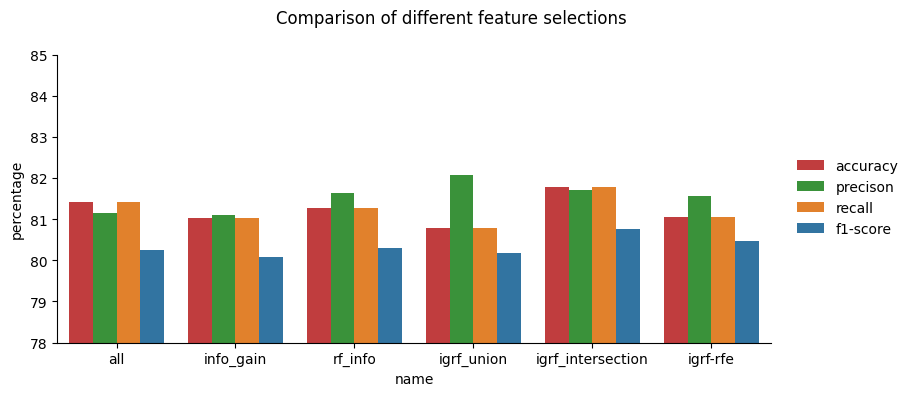

In [39]:
result_dfm = pd.melt(result_df, id_vars=("name"), value_vars=("accuracy", "precison", "recall", "f1-score"), var_name="metric", value_name="percentage")
g = sb.FacetGrid(result_dfm, height=4, aspect=2)
g.map_dataframe(sb.barplot, data=result_dfm, x="name", y="percentage", hue="metric", palette=["tab:red", "tab:green", "tab:orange", "tab:blue"])
g.fig.suptitle("Comparison of different feature selections")
g.set(ylim=(78, 85))
g.add_legend()
g.tight_layout()

In [40]:
result_df

,name,accuracy,precison,recall,f1-score
0,all,81.411035,81.151396,81.411035,80.246777
1,info_gain,81.019219,81.106716,81.019219,80.084360
2,rf_info,81.264724,81.644235,81.264724,80.309439
3,igrf_union,80.786113,82.063399,80.786113,80.164689
4,igrf_intersection,81.785493,81.719556,81.785493,80.749690
5,igrf-rfe,81.044017,81.562905,81.044017,80.462237


In [ ]:
# df_train.to_csv('../UNSW-NB15/data/UNSW_NB15_training-set_cleaned.csv', float_format='%f', index=False)
# df_test.to_csv('../UNSW-NB15/data/UNSW_NB15_testing-set_cleaned.csv', float_format='%f', index=False)